In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import os
from bs4 import BeautifulSoup  
import requests
import zipfile
import io


import geopandas as gpd
import shapely

# Load the Drive helper and mount
from google.colab import drive
mounted_path_folder = '/content/drive'
drive.mount(mounted_path_folder, force_remount=True)
curr_path_folder = "/content/drive/MyDrive/" # parent of current src folder

Mounted at /content/drive


In [24]:
# "https://drive.google.com/file/d/1bXMKg5p1jrk8uvCxT5SYAlYXBOOCJcUy/edit"
oa_orders = pd.read_csv(curr_path_folder+"offer_acceptance_orders.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,10,11,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
url_shapefile_location = "https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html"

page = requests.get(url_shapefile_location)

soup = BeautifulSoup(page.text, 'html.parser')

def get_shapefile_download_href(soup):
    temp_finder = soup.find_all('h3', text = "ZIP Code Tabulation Areas (ZCTAs)")[0]
    temp_finder = temp_finder.parent.find_next_sibling()
    shapefile_download_href = temp_finder.find_all("a",text="shapefile")[0]["href"]
    return shapefile_download_href

def create_zipcode_shapefile_folder(zipcode_shapefile_zipped_folder_name):
    global curr_path_folder
    path_folder_zipcode_shapefile = os.path.join(curr_path_folder, zipcode_shapefile_zipped_folder_name)
    os.makedirs(path_folder_zipcode_shapefile)
    return path_folder_zipcode_shapefile

def download_extract_shapefile_href_to_folder(shapefile_download_href, path_zipped_folder_zipcode_shapefile):
    r = requests.get(shapefile_download_href)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path_zipped_folder_zipcode_shapefile)

def get_zipcode_general_file_name(shapefile_download_href):
    zipcode_general_file_name = shapefile_download_href.split("/")[-1].split(".")[0]
    return zipcode_general_file_name

def get_zipcode_shapefile_name(zipcode_general_file_name):
    zipcode_shapefile_name = zipcode_general_file_name + ".shp"
    return zipcode_shapefile_name

def get_path_zipcode_shapefile(path_folder_zipcode_shapefile, zipcode_shapefile_name):
    path_zipcode_shapefile = os.path.join(path_folder_zipcode_shapefile, zipcode_shapefile_name)
    return path_zipcode_shapefile

shapefile_download_href = get_shapefile_download_href(soup)
path_folder_zipcode_shapefile = create_zipcode_shapefile_folder(r"zipcodes\\")
download_extract_shapefile_href_to_folder(shapefile_download_href, path_folder_zipcode_shapefile)
zipcode_general_file_name = get_zipcode_general_file_name(shapefile_download_href)
zipcode_shapefile_name = get_zipcode_shapefile_name(zipcode_general_file_name)
path_zipcode_shapefile = get_path_zipcode_shapefile(path_folder_zipcode_shapefile, zipcode_shapefile_name)


In [34]:
def geospatial_data_cleaning(path_zipcode_shapefile):
    '''
    Function that does all of the geospatial data preparation. 
    It takes in the zipcode shapefile, and gets the xy coordinats for each zipcode

    Args:
        path_zipcode_shapefile (str): the path to the shapefile

    Returns:
        GeoDataFrame: the dataframe with 3 columns - the zipcode, and the x and y coordinates.

    '''
    gdf_zipcode_column_name = "ZCTA5CE20"
    gdf_zipcode_3digits_column_name = "ZIP3"
    pseudo_mercator = 3857
    # see https://en.wikipedia.org/wiki/Web_Mercator_projection

    gdf = gpd.read_file(path_zipcode_shapefile, include_fields=["FID",gdf_zipcode_column_name])
    # the original zipcode column is a length 5 string of numbers (front-zeropadded)
    # but the zipcodes in matt's orders dataset are only the first 3 digits of the zipcode
    # so we add a new column that crops out 5digit zipcode to 3digits so it's usable as a foreign key
    gdf[gdf_zipcode_3digits_column_name] = gdf[gdf_zipcode_column_name].apply(lambda x: x[:3])


    gdf = gdf[["geometry",gdf_zipcode_3digits_column_name]]

    # projected the geometry from spherical to Flat 2D Map
    gdf = gdf.to_crs(pseudo_mercator)

    # But by cropping the 3 digits, we'd have to "dissolve" (basically a spatial version of groupby)
    # merge up all the zipcode polygons by their 3digits zipcode group.
    gdf_groupby = gdf.dissolve(
        by=gdf_zipcode_3digits_column_name,
        as_index=False
    )

    #gdf_groupby = gdf_groupby.simplify(0.1)

    print(gdf_groupby.crs) # debugger

    # create the centroids (x, y coords)
    gdf_groupby_centroids = gdf_groupby.centroid
    gdf_groupby["Xcoord"] = gdf_groupby_centroids.x
    gdf_groupby["Ycoord"] = gdf_groupby_centroids.y

    zipcoords = gdf_groupby[["ZIP3","Xcoord","Ycoord"]]

    return zipcoords

epsg:3857


In [35]:
zipcoords = geospatial_data_cleaning(path_zipcode_shapefile)
oa = oa_orders.copy()
oa = oa.merge(zipcoords, 
              left_on=["ORIGIN_3DIGIT_ZIP"], 
             right_on=["ZIP3"],
              suffixes=(None, "_orig")
             )

oa = oa.merge(zipcoords, 
              left_on=["DESTINATION_3DIGIT_ZIP"], 
             right_on=["ZIP3"],
              suffixes=(None, "_dest")
             )

Text(0.5, 1.0, 'Destinations of Orders')

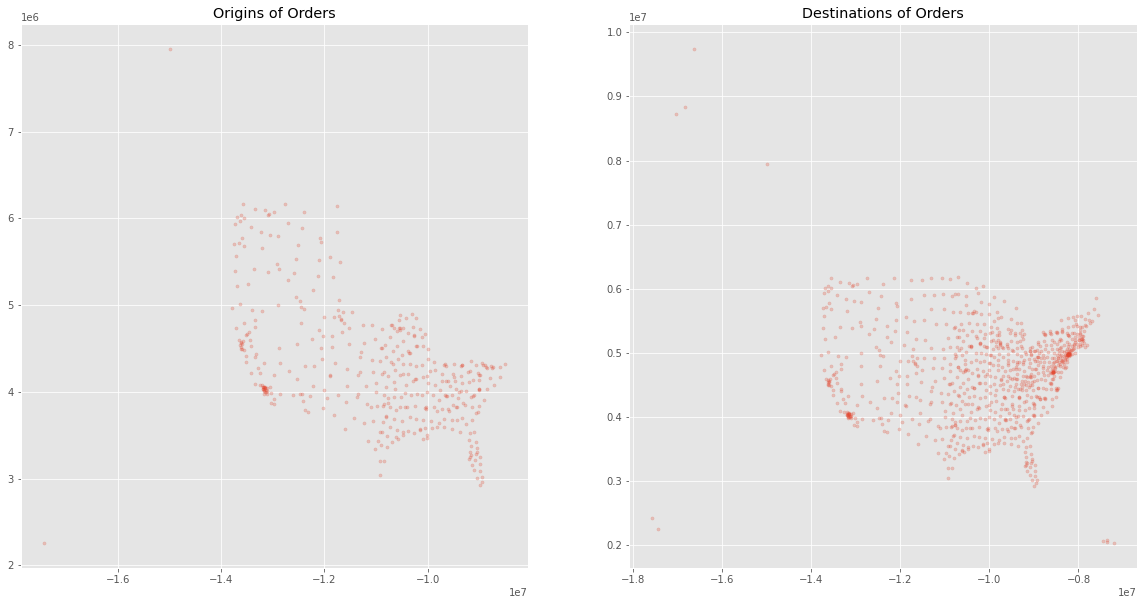

In [36]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
dotsize = 10
opacity = 0.25
orig_zip = oa[["Xcoord","Ycoord"]].drop_duplicates()
axs[0].scatter(orig_zip["Xcoord"],orig_zip["Ycoord"],alpha=opacity, s=dotsize)
axs[0].set_title("Origins of Orders")

dest_zip = oa[["Xcoord_dest","Ycoord_dest"]].drop_duplicates()
axs[1].scatter(dest_zip["Xcoord_dest"],dest_zip["Ycoord_dest"],alpha=opacity, s=dotsize)
axs[1].set_title("Destinations of Orders")

* If you take the euclidean distance between each rows' origin x/y and destination x/y. Then compare it against the APPROXIMATE_DRIVING_ROUTE_MILEAGE column, they are very linearly correlated. 

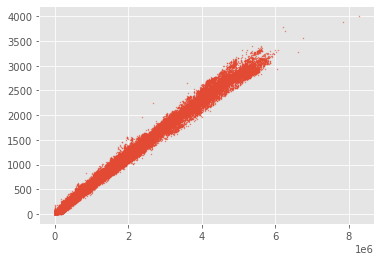

In [23]:
oa1 = oa[["Xcoord","Ycoord","Xcoord_dest","Ycoord_dest","APPROXIMATE_DRIVING_ROUTE_MILEAGE"]].drop_duplicates()

dist = np.sqrt((oa1["Xcoord_dest"] - oa1["Xcoord"])**2 + (oa1["Ycoord_dest"] - oa1["Ycoord"])**2)
plt.scatter(dist, oa1["APPROXIMATE_DRIVING_ROUTE_MILEAGE"],s=1,alpha=0.5)